# Average Mode FFT In/Out


The script demonstrates the use of average mode. The first sections connects & configures the system 
and sets the waveform generator. The latter sections define the average mode setting & digitizer sampling operation. 
The generator is configured on Channel-1, the signal is defined through a task table which consists of single cycle of "sin" wave followed by a "dc" quiet time.
An additional marker is defined on Marker-1 of channel 1 - currently in the half time of the active signal.

The digitizer is also configured on the input channel-1, so some loopback is required for the testing.
Starting from section: 'Average Mode Parameters', the average mode setting are defined 
and consists of the following:

#### Average Count up 1-16M
AvgCount=100000
#### Frame Size 1-10240
frame_size = 2400 
####  number_of_frames =1 : Should be fixed one.

In order to repeat tests with different parameters, you only need to replay sections starting from section: 'Average Mode Parameters'.
A background parameter called the AverageMSBShift - is set to be the log2 of the AvgCount parameter since the summing accumlators are limted to 36 bit. 

The resulting data is displayed in a "raw" & normalized forms at the end.




## Digitizer & Average Mode Configurations

In [30]:
#Digitizer Average Mode Settings 
##################################
#Average Count up 1-16M
AvgState = 'ON'
AvgCount=100000

number_of_frames =1 # Should be fixed one.
frame_size =  2400
##################################

DIG_SCLK = 2250e6
SCLK = DIG_SCLK * 4

DUC_NCO=100e6
DDC_NCO=100e6
full_scale = "HIGH"
print('Digitizer NCO is {0} Mhz'.format(DDC_NCO / 1e6))




Digitizer NCO is 100.0 Mhz


In [31]:
#Digitizer Average Mode Settings 
##################################
#Average Count up 1-16M
#Max Frame Size 1-10240

#Single Normal  mode - divide by 96 ~12 (e.g 
#Dual Normal  mode - divide by 48 ~6 (e.g 5000, 5024)
#Dual Normal FFT/Complex mode - divide by 24 ~6 & ~8(e.g 5118, 5106, 4992)
#Single Average Real mode - divide by 40 ~10 (e.g 5120, 5100)
#Dual Average Real mode - divide by 20 ~5 (e.g 5120, 5100)
#Dual Average Complex mode - divide by 16 ~5 (e.g 5120,5100)


##################################



In [32]:
import os
import sys
import gc
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst
from tevisainst import TEVisaInst

In [33]:
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt

lib_dir_path_= r'C:\Work_Svn\ProtuesAwgAverage\x64\Debug'


In [34]:
# Connect to instrument

inst = None
admin = None

conn_msg_str = ''

def disconnect():
    global inst
    global admin
    if inst is not None:
        try:
            inst.close_instrument()            
        except:
            pass
        inst = None
    if admin is not None:
        try:
            admin.close_inst_admin()
        except:
            pass
        admin = None
    gc.collect()

def connect_to_pxi_slot(slot_id):
    global inst
    global admin
    try:
        disconnect()        
        print("Trying to connect to PXI-slot:" + str(slot_id))
        admin = TepAdmin(lib_dir_path= lib_dir_path_)
        admin.open_inst_admin()        
        inst = admin.open_instrument(slot_id, reset_hot_flag=True)
    except:
        pass

def connect_to_lan_server(ip_address):
    global inst
    try:
        disconnect()
        print("Trying to connect to IP:" + ip_address)
        inst = TEVisaInst(ip_address, port=5025)
    except:
        pass

def connect(ipaddr_or_slotid):
    try:
        disconnect()
        if isinstance(ipaddr_or_slotid, str) and '.' in ipaddr_or_slotid:
            connect_to_lan_server(ipaddr_or_slotid)
        else:
            connect_to_pxi_slot(ipaddr_or_slotid)
    except:
        pass

addr_textbox = widgets.Text(
    value='',
    placeholder='IP Address or Slot Id',
    description='Address:',
    disabled=False
)

output = widgets.Output()

def print_conn_message(msg_str):
    global output
    global conn_msg_str
    with output:
        if len(conn_msg_str) > 0:
            print('\r', end='')
            print(' ' * len(conn_msg_str), end='')
            print('\r', end='')
        conn_msg_str = str(msg_str)
        if len(conn_msg_str) > 0:
            print(conn_msg_str, end='')

def on_button_connect_clicked(conn_str):
    global inst
    global addr_textbox
    print_conn_message('')
    disconnect()
    if addr_textbox is not None:
        conn_str = addr_textbox.value 
        if conn_str:
            print_conn_message('Connecting to {0} ..'.format(conn_str))
            connect(conn_str)
            print_conn_message('')
    if inst is not None:
        idn_str = inst.send_scpi_query('*IDN?')
        model = inst.send_scpi_query(":SYST:iNF:MODel?")
        if idn_str:
            prnmsg = 'Connected to: ' + idn_str.strip()
            print_conn_message(prnmsg)
            #print_conn_message('Connected to: ' + idn_str.strip())
            
    else:
        print_conn_message('Instrument not connected..')
    


In [35]:
connect("192.168.0.42")
#connect("8")


if inst is not None:
        idn_str = inst.send_scpi_query('*IDN?')
        model = inst.send_scpi_query(":SYST:iNF:MODel?")
        if idn_str:
            prnmsg = 'Connected to: ' + idn_str.strip()
            print(prnmsg)
else:
    print("Not connected")

pid = os.getpid()
print('process id {0}'.format(pid))

inst.send_scpi_cmd(':TRAC:DEL:ALL')
paranoia_level =2

model = inst.send_scpi_query(":SYST:iNF:MODel?")
print("\nModel: " + model)
# Infer the natural DAC waveform format
if 'P9082' in model:
    dac_mode = 8
else:
    dac_mode = 16
print("DAC waveform format: {0} bits-per-point".format(dac_mode))

if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0



inst.send_scpi_cmd("*CLS; *RST")

inst.send_scpi_cmd(':TRAC:DEL:ALL')
paranoia_level =2

    
print(dac_mode)

Trying to connect to IP:192.168.0.42
Connected to: Tabor Electronics,P9484,000000000000,1.222.0
process id 20160

Model: P9484
DAC waveform format: 16 bits-per-point
16


In [36]:
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(2500e6))
#inst.send_scpi_cmd(':FREQ:RAST {0}'.format(SCLK))
inst.send_scpi_cmd(':INT X{0}'.format(8))
inst.send_scpi_cmd(':MODE DUC')
inst.send_scpi_cmd(':IQM ONE')
inst.send_scpi_cmd(':NCO:CFR1 {0}'.format(DUC_NCO))
inst.send_scpi_cmd(':NCO:SIXD1 ON') # ON|OFF
inst.send_scpi_cmd(':ROSC:SOUR INT')
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(SCLK))

inst.send_scpi_cmd(':INST:CHAN {0}'.format(1))
inst.send_scpi_cmd(':OUTP:VOLT {0}'.format('0.4'))
inst.send_scpi_cmd(':INIT:CONT ON')
#inst.send_scpi_cmd(':TRAC:DEL:ALL')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)



#inst.send_scpi_cmd(":INST:CHAN 1")
#inst.send_scpi_cmd(":FREQ:RAST {0}".format(freq))
#inst.send_scpi_cmd(":INIT:CONT ON")



0, no error


In [37]:
resp = inst.send_scpi_query(':FREQ:RAST?')
print(resp)
resp = inst.send_scpi_query(':MODE?')
print(resp)
resp = inst.send_scpi_query(':IQM?')
print(resp)
resp = inst.send_scpi_query(':INT?')
print(resp)
resp = inst.send_scpi_query(':NCO:CFR1?')
print(resp)

9000000000.000
DUC
ONE
X8
100000000.000


## DC - Waveform 1 (Task 1)

2
0, no error


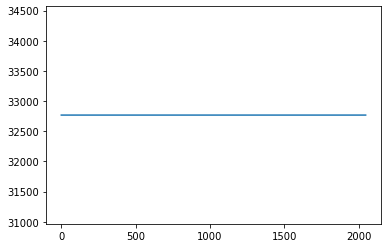

In [38]:
cycleLen = 2048
numCycles = 1
segLen = cycleLen * numCycles

# Build waveform (triangle wave)
y = np.ones(segLen)* half_dac
y = y.astype(data_type)
y.reshape(-1)

print(y.itemsize)
# Set Data as Task 1
#inst.send_scpi_cmd(':TRAC:DEF 1, {0}'.format(segLen*y.itemsize))
inst.send_scpi_cmd(':TRAC:DEF 1, {0}'.format(segLen)) #*y.itemsize))
inst.send_scpi_cmd(':TRAC:SEL 1')
# download the waveform to the selected Task
inst.write_binary_data(':TRAC:DATA', y)
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

plt.plot(y)


## Signal Waveform-2 (Task 2)

Build wave-data and download it to Proteus device.
0, no error


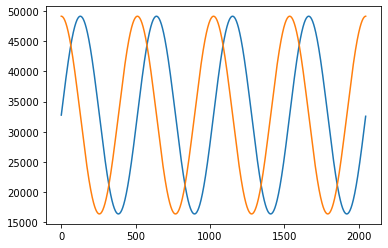

In [39]:
print('Build wave-data and download it to Proteus device.')
# Build two AWG segment that will be used as innput for the digitizer
paranoia_level = 2
cycleLen = 1024
numCycles = 4
segLen = cycleLen * numCycles

# Build sine waveform

x = np.linspace(
    start=0, stop=2 * np.pi * numCycles, num=segLen//2, endpoint=False)
y1 = (0.5*np.sin(x) + 1.0) * half_dac
y1 = np.round(y1)
y1 = np.clip(y1, 0, max_dac)
y1 = y1.astype(data_type)

y2 = (0.5*np.cos(x) + 1.0) * half_dac
y2 = np.round(y2)
y2 = np.clip(y2, 0, max_dac)
y2 = y2.astype(data_type)

wave = np.zeros(segLen)
wave[::2]= y1
wave[1::2]= y2
wave = wave.astype(data_type)

#wavey.reshape(-1)
# Download it to segment 1 of channel 1
#inst.send_scpi_cmd( ":TRAC:DEF 2," + str(segLen*y.itemsize), paranoia_level)
inst.send_scpi_cmd( ":TRAC:DEF 2," + str(segLen), paranoia_level)
inst.send_scpi_cmd( ":TRAC:SEL 2", paranoia_level)

inst.write_binary_data(':TRAC:DATA',wave)
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

plt.plot(y1)
plt.plot(y2)

## Configure Tasks

In [40]:
tak_half_dac = 0x80

inst.send_scpi_cmd(':INST:CHAN 1')          # Select channel
inst.send_scpi_cmd(':TASK:COMP:LENG 2')     # Set 2 Tasks in this Task Table


inst.send_scpi_cmd(':TASK:COMP:ENAB CPU')    # CPU trigger is the task enable
inst.send_scpi_cmd(':TASK:COMP:SEGM 1')      # play segment 1 (DC)
inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV {0}'.format(tak_half_dac))  # DC level while waiting to a trigger
inst.send_scpi_cmd(':TASK:COMP:NEXT1 2')     # the next task is 2     
    
inst.send_scpi_cmd(':TASK:COMP:SEL 2')
inst.send_scpi_cmd(':TASK:COMP:ENAB NONE')    # NONE trigger is the task enable
inst.send_scpi_cmd(':TASK:COMP:ABORt CPU')    # CPU trigger is the task enable
inst.send_scpi_cmd(':TASK:COMP:SEGM 2' )       # play segment 2 (Signal)
inst.send_scpi_cmd(':TASK:COMP:TYPE SINGle' )
inst.send_scpi_cmd(':TASK:COMP:DTRigger ON')   # issue a trigger to the ADC at start of segment
#inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV {0}'.format(task_half_dac))  # DC level while waiting to a trigger
inst.send_scpi_cmd(':TASK:COMP:LOOP 100' )       # repeat the segment 1 time
inst.send_scpi_cmd(':TASK:COMP:NEXT1 2')       # the next task is 3

inst.send_scpi_cmd(':TASK:COMP:WRIT' )   
print('Downloading Task table of channel 1')

 

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error


# Start Channel 1 at Task mode

In [41]:
# Enable channel 1
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':SOUR:VOLT:OFFSET 0.0')
#inst.send_scpi_cmd(':SOUR:VOLT: 0.0')
inst.send_scpi_cmd(':SOUR:VOLT MAX')
# Set Channel 1 to run task function
inst.send_scpi_cmd('FUNC:MODE TASK')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
inst.send_scpi_cmd(':OUTP ON')

0, no error


0

In [42]:

## Test generatation of  1 M signal events.
inst.send_scpi_cmd('*TRG')

0

# Setup Digitizer

In [43]:
#Digitizer Average Mode Settings 
##################################
#Average Count up 1-16M
AvgState = 'ON'
AvgCount=100000

In [44]:
#Clear DSP

# Select to store the FFT out data on memory 1
inst.send_scpi_cmd(':DSP:STOR1 DIR1') # DIRect1 | DIRect2 | DSP1 | DSP2 | DSP3 | DSP4| FFTIn | FFTOut
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Select to store the FFT in data on memory 2
inst.send_scpi_cmd(':DSP:STOR2 DIR2') # DIRect1 | DIRect2 | DSP1 | DSP2 | DSP3 | DSP4| FFTIn | FFTOut
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error
0, no error


In [45]:

## New Average Mode registers:
inst.send_scpi_cmd(':DIG:ACQuire:AVERage:STAT {0}'.format(AvgState))
inst.send_scpi_cmd(':DIG:ACQuire:AVERage:COUNt {0}'.format(AvgCount))


# Set DDC mode to complex
#inst.send_scpi_cmd(':DIG:DDC:MODE COMPlex')  # REAL | COMPlex
#inst.send_scpi_cmd(':DIG:DDC:DEC X16')  # REAL | COMPlex



print("Set Digitizer: Dual FFT Mode; internal Trigger")
#Set Dual channel mode
inst.send_scpi_cmd(':DIG:MODE DUAL')

# Set DDC mode to complex
inst.send_scpi_cmd(':DIG:DDC:MODE COMPlex')

# Set center frequency of channel 1
inst.send_scpi_cmd(':DIG:DDC:CFR1 {0}'.format(DDC_NCO))

# Set SCLK digitizer 
inst.send_scpi_cmd(':DIG:FREQ {0}'.format(DIG_SCLK))

# Set SYNC to SYSREF for phase coherance 
inst.send_scpi_cmd(':DIG:DDC:CLKS AWG')
#inst.send_scpi_cmd(':DIG:DDC:CLKS DIG')


# Set center frequency of channel 2
#inst.send_scpi_cmd(':DIG:DDC:CFR2 {0}'.format(DDC_NCO))


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

inst.send_scpi_cmd(':DIG:ACQuire:FRAM:DEF {0}, {1}'.format(number_of_frames, frame_size))
inst.send_scpi_cmd(':DIG:ACQuire:FRAM:CAPT 1, 1')
print("Set Digitizer: Frames:{0}, Frame Size:{1}".format(number_of_frames, frame_size))
# Set Trigger level to 0.2V
#inst.send_scpi_cmd(':DIG:TRIG:LEV1 -0.1')

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')

# Full scale select
inst.send_scpi_cmd(':DIG:CHAN:RANGe {0}'.format(full_scale)) # { LOW | MEDium | HIGH}


# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1') 

inst.send_scpi_cmd(':DIG:TRIG:AWG:TDEL {0}'.format(3e-7))

# Clean memory 
inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')


# Enable capturing data from channel 2
inst.send_scpi_cmd(':DIG:CHAN:SEL 2')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the internal-trigger as start-capturing trigger:

# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1') 
# Clean memory 
inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


resp = inst.send_scpi_query(':DIG:DDC:DEC?')
print(resp)

Set Digitizer: Dual FFT Mode; internal Trigger
0, no error
Set Digitizer: Frames:1, Frame Size:2400
0, no error
X16


###  DSP FFT Setup

In [46]:
# Select to store the FFT out data on memory 1
inst.send_scpi_cmd(':DSP:STOR1 FFTOut') # DIRect1 | DIRect2 | DSP1 | DSP2 | DSP3 | DSP4| FFTIn | FFTOut
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Select to store the FFT in data on memory 2
inst.send_scpi_cmd(':DSP:STOR2 FFTIn') # DIRect1 | DIRect2 | DSP1 | DSP2 | DSP3 | DSP4| FFTIn | FFTOut
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# select which input is routed to the FFT
inst.send_scpi_cmd(':DSP:FFT:INPut DBUG') # DSP1 | DSP3 |DBUG
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

FIR_BYPASS = 'ON'
# write FIR data to the DEBUG path
inst.send_scpi_cmd(':DSP:FIR:SEL DBUGI') # I1|Q1|I2|Q2|DBUGI|DBUGQ
inst.send_scpi_cmd(':DSP:FIR:BYPass '+FIR_BYPASS)
#inst.write_binary_data(':DSP:FIR:DATA', mem)
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

inst.send_scpi_cmd(':DSP:FIR:SEL DBUGQ') # I1|Q1|I2|Q2|DBUGI|DBUGQ
inst.send_scpi_cmd(':DSP:FIR:BYPass '+FIR_BYPASS)
#inst.write_binary_data(':DSP:FIR:DATA', mem)
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error
0, no error
0, no error
0, no error
0, no error


In [47]:
resp = inst.send_scpi_query(':DIG:MODE?')
print("Digitizer Mode:"+resp)

resp = inst.send_scpi_query(':DIG:ACQuire:AVERage:STAT?')
print("Average Mode:"+resp)

resp = inst.send_scpi_query(':DIG:ACQuire:AVERage:COUNt?')
print("Average Count:"+resp)

resp = inst.send_scpi_query(':SHELL:REG? 0x004060AC') 
print("Avg Sum shift:"+resp)
AvgShiftMSB = resp

resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:DEF?') 
print ("Frame size:"+ str(frame_size))
print(resp[2:])

# Set SYNC to SYSREF for phase coherance 
inst.send_scpi_cmd(':DIG:DDC:CLKS DIG')

resp = inst.send_scpi_query(':DIG:DDC:DEC?')
print(resp)

Digitizer Mode:DUAL
Average Mode:ON
Average Count:100000
Avg Sum shift:0x00000008
Frame size:2400
2400
X16


## Start Sampling Sequence

In [48]:
# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')


inst.send_scpi_cmd(':DIG:INIT ON')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)



0, no error


## Trigger Gen Signal & Acquire Data

In [49]:

## Currently Generates 1 M signal events.
inst.send_scpi_cmd('*TRG')

0

In [51]:

#"<frame-done-bit>,<all-frames-done-bit>,<counter-busy-bit>,<frames-counter>"
frameRx = 0
print("Waiting for acquire to complete.")
times = 0
while (frameRx != 1):
    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')
    framesParam = resp.split(",")
    frameRx = int(framesParam[3])
    times += 1
    time.sleep(0.1)
    if times > 100*AvgCount//10000:
        break
print(resp)


if (times<100):
    print("Digitizer: Finish Acquisition")
else:
    print('Could not finish acquire data- try again')

Waiting for acquire to complete.
1,1,0,1
Digitizer: Finish Acquisition


## Read Data

In [52]:
def getDataSize(digCh):
    inst.send_scpi_cmd(':DIG:CHAN:SEL {0}'.format(digCh))
    inst.send_scpi_cmd(':DIG:DATA:SEL ALL')
    inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')
    resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
    print(resp)
    num_bytes = np.uint32(resp)
    return num_bytes
    

In [53]:
inst.send_scpi_cmd(':DIG:INIT OFF')
#inst.send_scpi_cmd(':DIG:ACQuire:AVERage:STAT OFF')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Read the data that was captured by channel 1:
num_bytes1 = getDataSize(1)
print('Dig Ch:{0}, Total size in bytes: {1}'.format(1,num_bytes1))
num_bytes2 = getDataSize(2)
print('Dig Ch:{0}, Total size in bytes: {1}'.format(2,num_bytes2))
      

0, no error
9600
Dig Ch:1, Total size in bytes: 9600
9600
Dig Ch:2, Total size in bytes: 9600


In [56]:
datatype = np.uint32
 
    
print("== Ch1 ==")
# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = frame_size #num_bytes *2
if (wavlen != num_bytes1//np.dtype(datatype).itemsize):
  print ("Read size doesn't match frame size ")
else:
  wav1 = np.zeros(wavlen, dtype=datatype)
  print (wav1.nbytes)
  rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes1)
  resp = inst.send_scpi_query(':SYST:ERR?')
  print(resp)
  print("read data from DDR")


print("== Ch2 ==")
# Read the data that was captured by channel 2:
inst.send_scpi_cmd(':DIG:CHAN:SEL 2')

#wavlen = num_bytes2 // 4
if (wavlen != num_bytes2//np.dtype(datatype).itemsize):
  print ("Read size doesn't match frame size ")
else:
  wav2 = np.zeros(wavlen, dtype=datatype)
  print (wav2.nbytes)
  rc = inst.read_binary_data(':DIG:DATA:READ?', wav2, num_bytes2)
  resp = inst.send_scpi_query(':SYST:ERR?')
  print(resp)
  print("read data from DDR2")

== Ch1 ==
9600
0, no error
read data from DDR
== Ch2 ==
9600
0, no error
read data from DDR2


##  Plot Raw Data -  Binary Offset of 28 bit.

Count:100000, MSB Shift:0x00000008
Max:142612489, Min:115409825, Delta:27202664


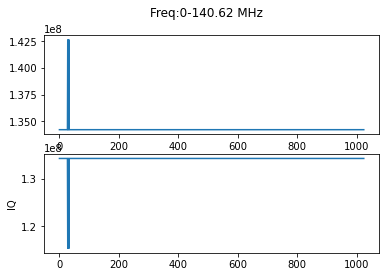

In [57]:
fig, axs = plt.subplots(2)
axs[0].plot(wav1[:2048:2])
plt.ylabel('IQ')
axs[1].plot(wav1[1:2048:2])


fig.suptitle('Freq:{0}-{1:.2f} MHz'.format(0,DIG_SCLK/(16*1e6)))

maxAvg = np.max(wav1)
minAvg = np.min(wav1)
print ("Count:{0}, MSB Shift:{1}".format(AvgCount, AvgShiftMSB))
print("Max:{0}, Min:{1}, Delta:{2}".format(maxAvg,minAvg,maxAvg-minAvg))

Count:100000, MSB Shift:0x00000008
Max:154804555, Min:113627586, Delta:41176969


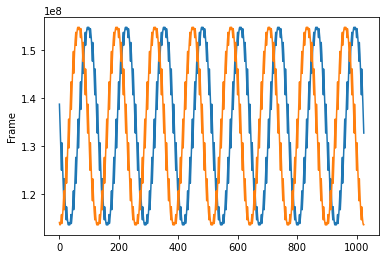

In [58]:
#fig, axs = plt.subplots(2)
plt.plot(wav2[0:2048:2])
plt.plot(wav2[1:2048:2])
plt.ylabel('Frame')
fig.suptitle('Count:')
maxAvg = np.max(wav2)
minAvg = np.min(wav2)
print ("Count:{0}, MSB Shift:{1}".format(AvgCount, AvgShiftMSB))
print("Max:{0}, Min:{1}, Delta:{2}".format(maxAvg,minAvg,maxAvg-minAvg))

### Normalize to Signed number 

In [59]:
def MsbCutoff(AvgCount, realComplex):
    cutIdx = 14 if realComplex else 11
    for i in range(31,cutIdx,-1):
      if ((1 << i) & AvgCount) != 0:
            break;
    log2FrameFactor = 1 << (i - cutIdx-1);
    return log2FrameFactor;

Count:100000, MSB Shift:0x00000008
Max:1343.16176, Min:-3009.26448, Delta:4352.42624


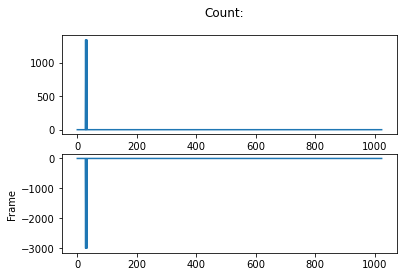

In [60]:
wavNormFft = np.add(wav1, - np.power(2,27)) * MsbCutoff(AvgCount,False)/AvgCount

fig, axs = plt.subplots(2)
axs[0].plot(wavNormFft[:2048:2])

axs[1].plot(wavNormFft[1:2048:2])

plt.ylabel('Frame')
fig.suptitle('Count:')
maxAvg = np.max(wavNormFft)
minAvg = np.min(wavNormFft)
print ("Count:{0}, MSB Shift:{1}".format(AvgCount, AvgShiftMSB))
print("Max:{0}, Min:{1}, Delta:{2}".format(maxAvg,minAvg,maxAvg-minAvg))


Count:100000, MSB Shift:0x00000008
Max:3293.89232, Min:-3294.42272, Delta:6588.3150399999995


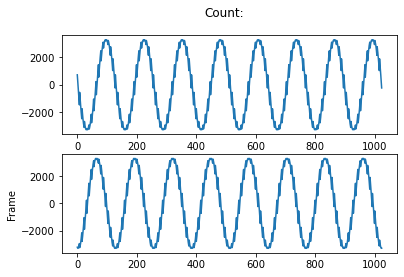

In [61]:
wavNorm = np.add(wav2, - np.power(2,27)) * MsbCutoff(AvgCount,False)/AvgCount

fig, axs = plt.subplots(2)
axs[0].plot(wavNorm[:2048:2])

axs[1].plot(wavNorm[1:2048:2])

plt.ylabel('Frame')
fig.suptitle('Count:')
maxAvg = np.max(wavNorm)
minAvg = np.min(wavNorm)
print ("Count:{0}, MSB Shift:{1}".format(AvgCount, AvgShiftMSB))
print("Max:{0}, Min:{1}, Delta:{2}".format(maxAvg,minAvg,maxAvg-minAvg))


In [ ]:

if (AvgState == 'ON'):
  np.savetxt("results/avgFftNormCount{0}.csv".format(AvgCount),wavNormFft)
  np.savetxt("results/avgWaveNormCount{0}.csv".format(AvgCount),wavNorm)
else:
  wav1f = np.subtract(wav1,16384.0)
  wav2f = np.subtract(wav2,16384.0)
  np.savetxt("results/avgFftNormCount0.csv",wav1f)
  np.savetxt("results/avgWaveNormCount0.csv",wav2f)

In [62]:
inst.close_instrument()
#admin.close_inst_admin()